In [1]:
import time, matplotlib, sklearn

# visualizatoin 
import matplotlib.pyplot as plt 
import seaborn as sns
# data wrangling
import pandas as pd
import numpy as np 

# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc, RocCurveDisplay
from sklearn.calibration import calibration_curve
from sklearn.base import BaseEstimator, TransformerMixin

# learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


# the data intro has been tested with the following versions
print("pandas        Tested version: 2.0.3   Your version: %s" % pd.__version__)
print("numpy         Tested version: 1.21.5  Your version: %s" % np.__version__)
print("matplotlib    Tested version: 3.5.3   Your version: %s" % matplotlib.__version__)
print("scikit-learn  Tested version: 1.2.2   Your version: %s" % sklearn.__version__)

pandas        Tested version: 2.0.3   Your version: 1.5.3
numpy         Tested version: 1.21.5  Your version: 1.23.5
matplotlib    Tested version: 3.5.3   Your version: 3.6.2
scikit-learn  Tested version: 1.2.2   Your version: 1.2.1


In [2]:
# description
description = pd.read_csv('WiDS_Datathon_2020_Dictionary.csv')
description_dict = description.set_index('Variable Name').to_dict(orient='index')
# data
df = pd.read_csv('training_v2.csv')
# drop sensitive features
df = df.drop(columns=['age', 'ethnicity', 'gender'])
df.head()

,encounter_id,patient_id,hospital_id,hospital_death,bmi,elective_surgery,height,hospital_admit_source,icu_admit_source,icu_id,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,22.73,0,180.3,Floor,Floor,92,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,27.42,0,160.0,Floor,Floor,90,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,31.95,0,172.7,Emergency Department,Accident & Emergency,93,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,22.64,1,165.1,Operating Room,Operating Room / Recovery,92,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,NaN,0,188.0,NaN,Accident & Emergency,91,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [3]:
test_size = 0.2 # proportion for train versus test+val split
val_size = 0.5 # proportion for test versus val split
random_state = 42  # random state is used to set a seed for randomness, which is only relevant for reproducibility purposes
max_missing = 0.7  # maximum percentage of missing values for a column to be dropped

In [4]:
class DropHighlyCorrelatedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.8):
        self.threshold = threshold
        self.features_to_drop = None

    def fit(self, X, y=None):
        # Calculate the correlation matrix
        X = pd.DataFrame(X)
        corr_matrix = X.corr()

        # Find pairs of features that are highly correlated
        highly_correlated = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if (corr_matrix.loc[i, j] > self.threshold) and (i != j)]

        # Remove one feature from each highly correlated pair
        self.features_to_drop = set()
        for i, j in highly_correlated:
            if i not in self.features_to_drop and j not in self.features_to_drop:
                self.features_to_drop.add(j)

        return self

    def transform(self, X):
        # Drop the highly correlated features
        X = pd.DataFrame(X)
        X_reduced = X.drop(columns=self.features_to_drop)
        return X_reduced

    def get_feature_names_out(self, input_features=None):
        new_features = []
        for i, feature in enumerate(input_features):
            if i not in self.features_to_drop:
                new_features.append(feature)
        return np.array(new_features)

In [5]:
start_time = time.time()

# save features
X = df.copy().drop(['hospital_death', 'patient_id', 'encounter_id', 'hospital_id', 'icu_id', # drop identifiers
                    'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', # drop APACHE scores
                    'apache_2_bodysystem', # drop because of similarity with apache_3j_bodysystem
                    # "ethnicity" # Check if can be dropped
                    ],
                   axis=1)
# save target variable
y = df['hospital_death'].copy()
# save APACHE scores for later evaluation on train / test / validation data
y_apache = df['apache_4a_hospital_death_prob'].copy()

""" SPLIT DATA SET """
# split the dataset into train and test+validation set
(
    X_train,
    X_test,
    y_train,
    y_test,
    y_apache_train,
    y_apache_test,
    ) = train_test_split(X, y, y_apache, 
                         test_size=test_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 
# split the test set into test + validation set
(
    X_val,
    X_test,
    y_val,
    y_test,
    y_apache_val,
    y_apache_test,
    ) = train_test_split(X_test, y_test, y_apache_test, 
                         test_size=val_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 

"""MISSING VALUES"""
# drop columns with many missing values
missing = X_train.isna().sum() > max_missing * len(X_train)
missing = missing[missing].index
X_train = X_train.drop(missing, axis=1)
X_val = X_val.drop(missing, axis=1)
X_test = X_test.drop(missing, axis=1)

"""FURTHER PROCESSING PIPELINE"""
# define pre-processing steps for numerical features
num_transformer = Pipeline(steps=[("constant", VarianceThreshold()), # remove constant features
                                  ("drop_correlated", DropHighlyCorrelatedFeatures(threshold=0.8)),
                                  ("imputer", SimpleImputer(strategy="mean")),
                                  ("scaling", RobustScaler(quantile_range=(10, 90))),
                                 ])
# define preprocessing steps for categorical features
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="MISSING")),
    ("encoder", OneHotEncoder(drop='first', sparse_output=False, handle_unknown="ignore")),
    ("constant", VarianceThreshold())
    ])
# create preprocessing pipeline
prep_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_transformer, make_column_selector(dtype_exclude=object)), # apply to columns NOT of type object (int or float)
        ('cat', cat_transformer, make_column_selector(dtype_include=object)) # apply to columns of type object
    ])

prep_pipeline.fit(X_train, y_train)
display(prep_pipeline) # display preprocessing pipeline

# transform data sets
X_train = pd.DataFrame(prep_pipeline.transform(X_train), columns=prep_pipeline.get_feature_names_out())
X_val = pd.DataFrame(prep_pipeline.transform(X_val), columns=prep_pipeline.get_feature_names_out())
X_test = pd.DataFrame(prep_pipeline.transform(X_test), columns=prep_pipeline.get_feature_names_out())
        
"""PRINT STATS"""
print("Time: %.2fs" % (time.time() - start_time))
print("Train set: %s rows, %s columns" % X_train.shape)
print("Validation set: %s rows, %s columns" % X_val.shape)
print("Test set: %s rows, %s columns" % X_test.shape)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('constant',
                                                  VarianceThreshold()),
                                                 ('drop_correlated',
                                                  DropHighlyCorrelatedFeatures()),
                                                 ('imputer', SimpleImputer()),
                                                 ('scaling',
                                                  RobustScaler(quantile_range=(10,
                                                                               90)))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000025D7ADC3190>),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('constant',
                                                  VarianceThreshold())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000025D79D4BBB0>)])

Time: 1.82s
Train set: 73370 rows, 108 columns
Validation set: 9171 rows, 108 columns
Test set: 9172 rows, 108 columns


## Evaluation

In [6]:
def plotCFMatrix(cm): # input is the confusion matrix from sklearn
    
    plt.figure(figsize=(8, 6))  
    sns.set_style("whitegrid") 
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

In [7]:
def Metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'TPR: {tpr}')
    print(f'TNR: {tnr}')
    return accuracy, precision, recall, f1, tpr, tnr

In [8]:
def calibration_plot(y_true, y_prob, model_name):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
    
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label=model_name)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'Calibration Plot of {model_name}')
    plt.legend()
    plt.show()

## XGBoost Model

In [9]:
parameters = {
    'n_estimators': [50,100,200,500,1000],
    'learning_rate': [0.1, 0.3, 0.6, 0.8, 1.0],
    'max_depth': [1,3,6,10],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.1, 0.5, 1.0, 1.5],
}

In [10]:
# xg = xgb.XGBClassifier(random_state=42)
# g = RandomizedSearchCV(xg, parameters, cv=5, n_jobs=8)
# g.fit(X_train, y_train)
# cls_params = g.best_params_
# cls_params

In [11]:
xg = xgb.XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.1,
    n_estimators=100,
    max_depth=10,
    reg_lambda=1.0,
    reg_alpha=0.0,
    random_state=42
)
xg.fit(X_train, y_train)
xg_pred = xg.predict(X_val)
xg_pred_proba = xg.predict_proba(X_val)[:, 1]

In [12]:
cm_xg = confusion_matrix(y_val, xg_pred)
accuracy_xg, precision_xg, recall_xg, f1_xg, tpr_xg, tnr_xg = Metrics(y_val, xg_pred)

Accuracy: 0.93
Precision: 0.74
Recall: 0.32
F1 Score: 0.45
TPR: 0.3241206030150754
TNR: 0.9891343283582089


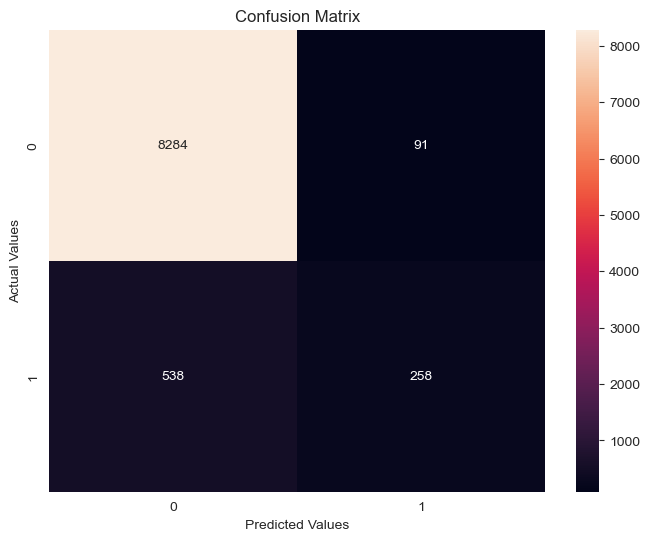

In [13]:
plotCFMatrix(cm_xg)

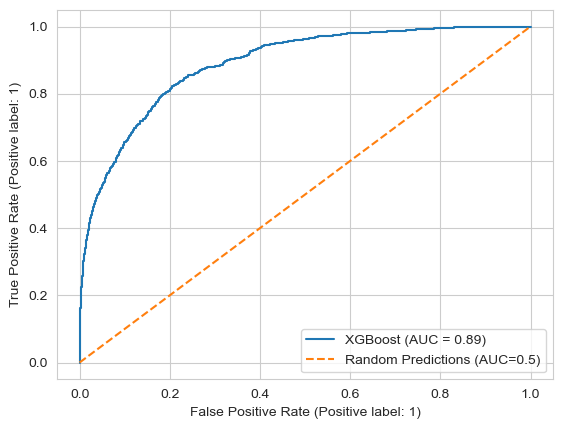

In [14]:
RocCurveDisplay.from_predictions(y_true=y_val, y_pred=xg_pred_proba, name='XGBoost')
plt.plot([0, 1], [0, 1], linestyle="--", label='Random Predictions (AUC=0.5)')
plt.legend()
plt.show()

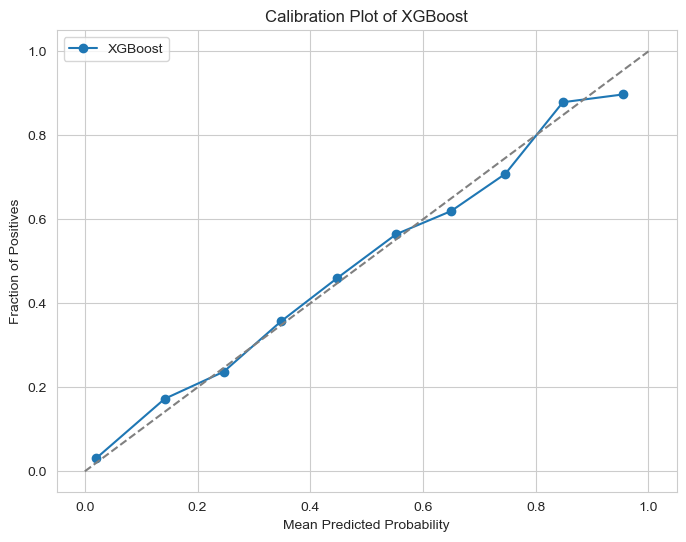

In [15]:
calibration_plot(y_val, xg_pred_proba, "XGBoost")

Top 10 most important features for XGBoost

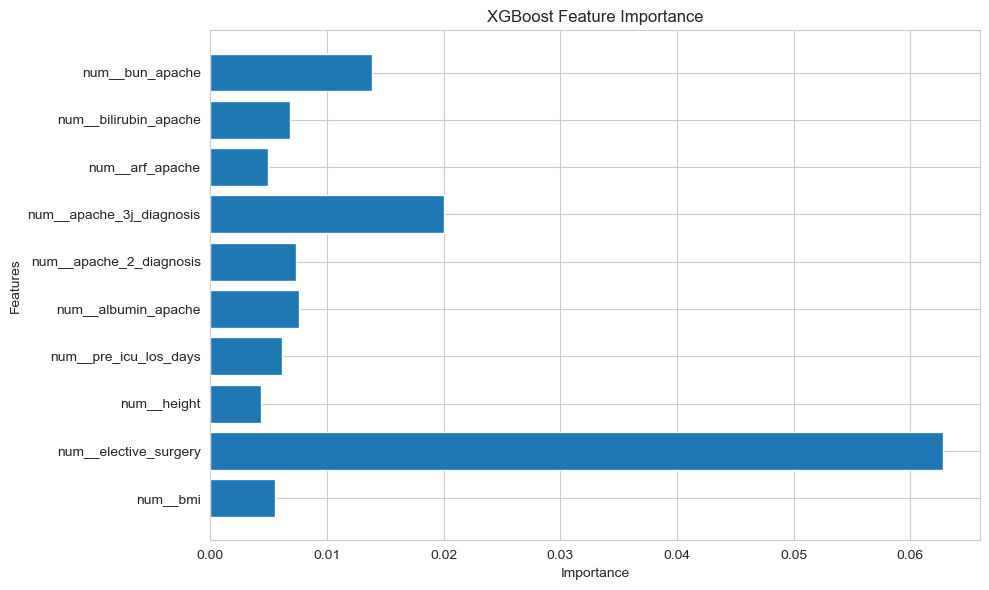

In [16]:
plt.figure(figsize=(10, 6))
plt.barh(range(10), xg.feature_importances_[:10])
plt.yticks(range(10), X_train.columns[:10])
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()